## Kernel PCA
#### Team members: Liule Yang, Zhiwen Xu, Yuxuan Liu

## Background and motivation

Principal component analysis (PCA) is one of the most popular dimensionality reduction and data visualization right now (Bishop, 561). PCA can extract linear features of a matrix input data and some meaningful analysis can be performed based on that. PCA can be performed through eigen-decomposition as well as singular value decomposition (SVD). PCA works well in some cases, for example, when dealing with DNA sequences, it can achieve satisfactory results.

However, PCA can only extract linear features. When the data is not linearly separable, we need to do a kernel trick and here we need kernel PCA (KPCA). With the KPCA, we can extract nonlinear features. Common kernels for KPCA include polynomial kernel, Gaussian kernel, and Sigmoid kernel.

## Theory

## Implementation

#### The eigen decomposition implementation of PCA

The first type of algorithm is utilizing the information from eigenvalues and eigenvectors. First, the input matrix will be standardized by deducting mean of the matrix. Then, the covariance matrix of the input matrix will be computed, and the eigenvector and eigenvalue will be computed based on the covariance matrix. Then, sort the eigenvectors based on eigenvalues from large to small, and then select the top n components to make transformation of the original input matrix to a matrix with n features (n columns).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def eigen_pca(m, n_components = 2):
    # compute the mean and make the input matrix centered
    mean = np.mean(m,0)
    centered_m = m - mean
    num_rows, num_cols = centered_m.shape
    # compute covariance matrix
    cov_matrix = np.cov(np.transpose(centered_m))
    # compute eigenvector and eigenvalue
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_matrix)
    # sort the eigenvalue and eigenvector pair by the order of eigenvector from large to small
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    # transform to the reduced dimension dataset
    transformation_maxtrix = np.hstack((eig_pairs[k][1].reshape(num_cols,1) for k in range(n_components)))
    reduced = (transformation_maxtrix.transpose()).dot(centered_m.transpose())
    return reduced

#### The SVD implementation of PCA

The PCA can also be performed using SVD. For the preprocessing of the data, the input data still needs to be centered. For this time, we do not use covariance matrix and then compute eigenvalues and eigenvectors based on that. Instead, this algorithm will perform SVD decomposition, and then utilize the first n largest singular value to reduce the dimensionality. Note singular values are already ordered from large to small when performing SVD, so there is no need to perform an ordering algorithm again.

In [4]:
def svd_pca(m, n_components = 2):
    # compute the mean and make the input matrix centered
    mean = np.mean(m,0)
    centered_m = m - mean
    # perform singular value decomposition
    U, S, V_transpose = np.linalg.svd(centered_m, full_matrices=False)
    S = np.diag(S)
    # reduce the dimensionality
    reduced = (S[0:n_components, 0:n_components]).dot(U[:, 0:n_components].transpose())
    return reduced

#### Gaussian radial basis function (RBF) Kernel

This is the implementation of the Gaussian RBF kernel. This function takes an MxN data matrix and returns an MxM kernel matrix mapped by the kernel function. It first calculates the pairwise Euclidean distances of data points and transforms the result into an MxM symmetric matrix. Then it applies the RBF kernel function over this matrix and outputs the result.

In [5]:
from numpy import exp
import numpy as np
import math

def gaussian_kernel(X, gamma):
    # calculate the square of the Euclidean distance for each pair of points
    distances = []
    num_rows, num_cols = X.shape
    for i in range(0,len(X)-1):
      for j in range(i+1,len(X)):
        distances.append(sum(pow(X[i][k] - X[j][k],2) for k in range(num_cols)))
    # convert the squared distances in to the form of a symmetric matrix of dimension MxM
    s = (len(X),len(X))
    square = np.zeros(s)
    idx = 0
    for i in range(0,len(X)):
      for j in range(i+1,len(X)):
        square[i][j] = distances[idx]
        square[j][i] = distances[idx]
        idx += 1
    # calculated the MxM kernel matrix using the Gaussian RBF kernel function
    K = exp(-gamma * square)
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    return K

#### Polynomial Kernel

This is the implementation of the Polynomial kernel. This function takes an MxN data matrix and returns an MxM kernel matrix mapped by the kernel function. It first calculates the pairwise dot products data points and transforms the result into an MxM symmetric matrix. Then it applies the polynomial kernel function over this matrix and outputs the result.

In [6]:
def poly_kernel(X, p):
    # calculate the dot product for each pair of points
    products = []
    for i in range(0,len(X)-1):
      for j in range(i+1,len(X)):
        products.append(X[i] @ X[j])
    # convert the squared distances in to the form of a symmetric matrix of dimension MxM
    s = (len(X),len(X))
    square = np.zeros(s)
    idx = 0
    for i in range(0,len(X)):
      for j in range(i+1,len(X)):
        square[i][j] = products[idx]
        square[j][i] = products[idx]
        idx += 1
    # calculated the MxM kernel matrix using the polynomial kernel function
    K = pow(1 + square, p)
    return K

#### Sigmoid Kernel PCA

This is the implementation of the Sigmoid kernel. This function takes an MxN data matrix and returns an MxM kernel matrix mapped by the kernel function. It first calculates the pairwise dot products data points and transforms the result into an MxM symmetric matrix. Then it applies the sigmoid kernel function over this matrix and outputs the result.

In [7]:
def sigmoid_kernel(X, sigma):
    # calculate the dot product for each pair of points
    products = []
    for i in range(0,len(X)-1):
      for j in range(i+1,len(X)):
        products.append(X[i] @ X[j])
    # convert the squared distances in to the form of a symmetric matrix of dimension MxM
    s = (len(X),len(X))
    square = np.zeros(s)
    idx = 0
    for i in range(0,len(X)):
      for j in range(i+1,len(X)):
        square[i][j] = products[idx]
        square[j][i] = products[idx]
        idx += 1
    # calculated the MxM kernel matrix using the sigmoid kernel function
    square = square + sigma
    for i in range(0,len(X)):
      for j in range(0,len(X)):
        square[i][j] = math.tanh(square[i][j])
    return square

## Data

#### Inroduction of test data

We are going to use DNA sequences to test whether KPCA can visualize a more meaningful clustering. We are going to perform KPCA on bat flu and cat flu dataset. For the preprocessing of the dataset, we utilized k-mer technique, which is a common technique when dealing with unaligned biological sequences. Basically, a k-mer is one of the permutations of the four letters, 'A', 'T', 'C', 'G', of length k. For example, a 2-mer will can be 'AA', 'AT', 'TA', and so on. When applying k-mer to DNA sequences, the number of appearences of each k-mer will be counted for each sequence, and a k-mer table will be created, and the table will be regarded as an input matrix.

First, load the DNA sequence data file and create the k-mer table. The two packages are imported only for the processing the biological sequence data and create k-mer table and have nothing to do with the implementation of KPCA.

In [15]:
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer

def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def read_fasta(paths):
    all_genes = []
    all_gene_len = []
    
    for path in paths:
        virus = parseFasta(path)
        virus = virus.drop_duplicates(keep="last")
        genes = list(virus['Sequence'])
        genes_seq = get_gene_sequences(path)
        gene_len = get_gene_len(genes_seq)
        all_genes = all_genes + genes_seq
        all_gene_len = all_gene_len + gene_len
    return all_genes,all_gene_len

def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

def get_kmer_table(paths,k_min,k_max):
    genes,gene_len = read_fasta(paths)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input

bat_len = len(get_gene_sequences("bat_flu.fa"))
cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
paths = ["combined_Bat_Cat_flu.fa"]
kmer_table = get_kmer_table(paths, 4, 4);


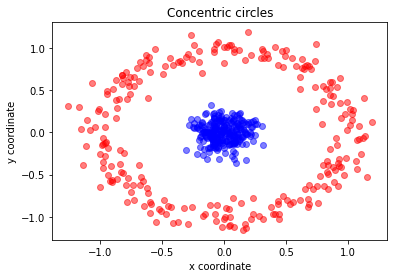

In [8]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, random_state=0, noise=0.1, factor=0.1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Concentric circles')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

#### Performance of PCA

From the result below, it can be seen that around the center of the scatterplot, two clusters are not separated enough, and the performance is not ideal.

c:\users\liule\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


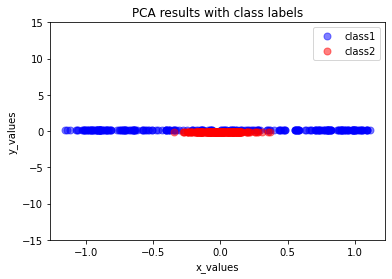

In [11]:
pca_result = eigen_pca(X, n_components = 1)
pca_result = pca_result.transpose()
plt.ylim([-15,15])
plt.plot(pca_result[y==0,0],np.zeros((250,1))+0.1 ,'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(pca_result[y==1,0],np.zeros((250,1))-0.1,'o', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('PCA results with class labels')
plt.show()

#### Performances of KPCA

Gaussian KCPA

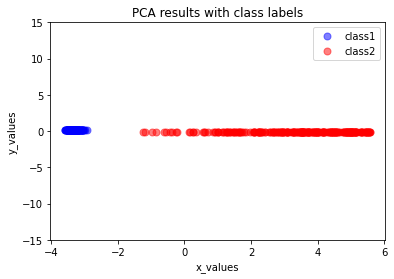

In [13]:
gaussian_transformed = gaussian_kernel(X, 15)
gaussian_KPCA_result = svd_pca(gaussian_transformed, n_components = 1)
gaussian_KPCA_result = gaussian_KPCA_result.transpose()
plt.ylim([-15,15])
plt.plot(gaussian_KPCA_result[y==0, 0],np.zeros((250,1))+0.1 ,'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(gaussian_KPCA_result[y==1, 0],np.zeros((250,1))-0.1,'o', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('PCA results with class labels')
plt.show()

Polynomial KPCA

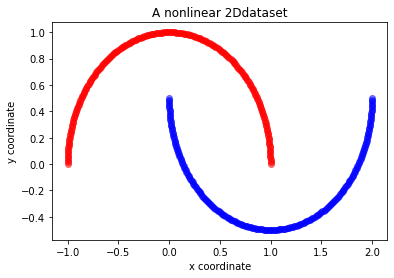

In [17]:
X, y = make_moons(n_samples=500, random_state=535)

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

c:\users\liule\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


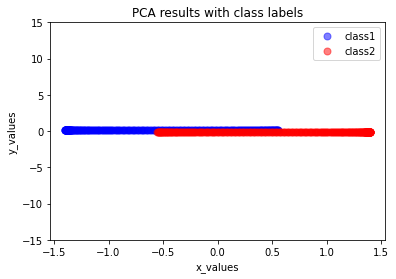

In [18]:
pca_result = eigen_pca(X, n_components = 1)
pca_result = pca_result.transpose()
plt.ylim([-15,15])
plt.plot(pca_result[y==0,0],np.zeros((250,1))+0.1 ,'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(pca_result[y==1,0],np.zeros((250,1))-0.1,'o', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('PCA results with class labels')
plt.show()

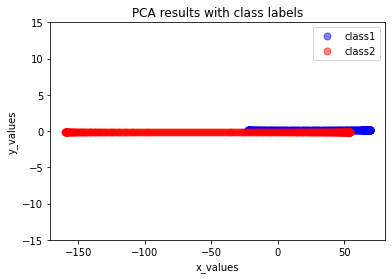

In [26]:
poly_transformed = poly_kernel(X, 2)
poly_KPCA_result = svd_pca(poly_transformed, n_components = 2)
poly_KPCA_result = poly_KPCA_result.transpose()
plt.ylim([-15,15])
plt.plot(poly_KPCA_result[y==0, 0],np.zeros((250,1))+0.1 ,'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(poly_KPCA_result[y==1, 0],np.zeros((250,1))-0.1,'o', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('PCA results with class labels')
plt.show()

Sigmoid KPCA

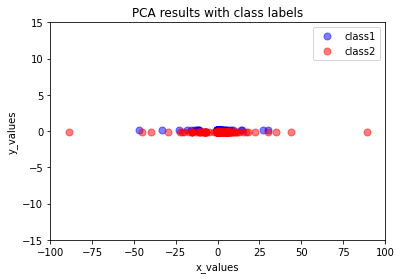

In [32]:
sigmoid_transformed = sigmoid_kernel(X, 5)
sigmoid_KPCA_result = svd_pca(sigmoid_transformed, n_components = 2)
sigmoid_KPCA_result = sigmoid_KPCA_result.transpose()
plt.ylim([-15,15])
plt.plot(sigmoid_KPCA_result[y==0, 0],np.zeros((250,1))+0.1 ,'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sigmoid_KPCA_result[y==1, 0],np.zeros((250,1))-0.1,'o', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('PCA results with class labels')
plt.show()

## References